<a href="https://colab.research.google.com/github/vjkr/OpenLaneASICflow/blob/main/MLR1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OpenLane Setup

In [1]:
%%capture
# @title Setup Nix {display-mode: "form"}
import os
import sys
import shutil

os.environ["LOCALE_ARCHIVE"] = "/usr/lib/locale/locale-archive"

if "google.colab" in sys.modules:
    if shutil.which("nix-env") is None:
        !curl -L https://nixos.org/nix/install | bash -s -- --daemon --yes
        !echo "extra-experimental-features = nix-command flakes" >> /etc/nix/nix.conf
        !killall nix-daemon
else:
    if shutil.which("nix-env") is None:
        raise RuntimeError("Nix is not installed!")

os.environ["PATH"] = f"/nix/var/nix/profiles/default/bin/:{os.getenv('PATH')}"

In [8]:
%%capture
# @title Get OpenLane {display-mode: "form"}

import os
import subprocess
import IPython

openlane_version = "version-2.1"

if openlane_version == "latest":
    openlane_version = "main"

pdk_root = "~/.volare"

pdk_root = os.path.expanduser(pdk_root)

pdk = "sky130"

openlane_ipynb_path = os.path.join(os.getcwd(), "openlane_ipynb")

display(IPython.display.HTML("<h3>Downloading OpenLane…</a>"))


TESTING_LOCALLY = False
!rm -rf {openlane_ipynb_path}
!mkdir -p {openlane_ipynb_path}
if TESTING_LOCALLY:
    !ln -s {os.getcwd()} {openlane_ipynb_path}
else:
    !curl -L "https://github.com/efabless/openlane2/tarball/{openlane_version}" | tar -xzC {openlane_ipynb_path} --strip-components 1

try:
    import tkinter
except ImportError:
    if "google.colab" in sys.modules:
        !sudo apt-get install python-tk

try:
    import tkinter
except ImportError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to import the <code>tkinter</code> library for Python, which is required to load PDK configuration values. Make sure <code>python3-tk</code> or equivalent is installed on your system.</a>'
        )
    )
    raise e from None


display(IPython.display.HTML("<h3>Downloading OpenLane's dependencies…</a>"))
try:
    subprocess.check_call(
        ["nix", "profile", "install", ".#colab-env", "--accept-flake-config"],
        cwd=openlane_ipynb_path,
    )
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install binary dependencies using Nix…</h3>'
        )
    )

display(IPython.display.HTML("<h3>Downloading Python dependencies using PIP…</a>"))
try:
    subprocess.check_call(
        ["pip3", "install", "."],
        cwd=openlane_ipynb_path,
    )
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install Python dependencies using PIP…</h3>'
        )
    )
    raise e from None

display(IPython.display.HTML("<h3>Downloading PDK…</a>"))
import volare

volare.enable(
    volare.get_volare_home(pdk_root),
    pdk,
    open(
        os.path.join(openlane_ipynb_path, "openlane", "open_pdks_rev"),
        encoding="utf8",
    )
    .read()
    .strip(),
)

sys.path.insert(0, openlane_ipynb_path)
display(IPython.display.HTML("<h3>⭕️ Done.</a>"))

import logging

# Remove the stupid default colab logging handler
logging.getLogger().handlers.clear()

In [12]:
%%capture
# @title bring sample designs
!git clone https://github.com/vjkr/OpenLaneASICflow.git

In [13]:
# @title config
%%capture
from openlane.config import Config

Config.interactive(
    "alu",
    PDK="sky130A",
    CLOCK_PORT="clk",
    CLOCK_NET="clk",
    CLOCK_PERIOD=10,
    PRIMARY_GDSII_STREAMOUT_TOOL="klayout",
)


In [31]:
# @title Step 1 Synthesis
%%capture
from openlane.steps import Step
Synthesis = Step.factory.get("Yosys.Synthesis")
from openlane.state import State

synthesis = Synthesis(
    VERILOG_FILES=["./OpenLaneASICflow/alu.v"],
    state_in=State(),
)
synthesis.start()


In [78]:
# @title Synthesis Result : Netlist & stats
print(" -----------------------------------------------")
print("| Netlist file generated at openlane_run       |")
print("| ./openlane_run/1-yosys-synthesis/alu.nl.v    |")
print(" -----------------------------------------------")

# f = open('./openlane_run/7-yosys-synthesis/alu.nl.v', 'r')
# file_contents = f.read()
# print (file_contents)
# f.close()
# Path to the log file
log_path = "/content/openlane_run/7-yosys-synthesis/reports/stat.log"

# Read and print the log file
with open(log_path, "r") as file:
    log_content = file.read()  # Read entire log file

# Print the log content
print(log_content)

 -----------------------------------------------
| Netlist file generated at openlane_run       |
| ./openlane_run/1-yosys-synthesis/alu.nl.v    |
 -----------------------------------------------
61. Printing statistics.

=== alu ===

   Number of wires:                290
   Number of wire bits:            321
   Number of public wires:          99
   Number of public wire bits:     130
   Number of memories:               0
   Number of memory bits:            0
   Number of processes:              0
   Number of cells:                286
     sky130_fd_sc_hd__a21o_2         1
     sky130_fd_sc_hd__a31o_2        31
     sky130_fd_sc_hd__and2_2        32
     sky130_fd_sc_hd__dfrtp_2       64
     sky130_fd_sc_hd__inv_2         64
     sky130_fd_sc_hd__nand2_2       31
     sky130_fd_sc_hd__nand3_2        1
     sky130_fd_sc_hd__xnor2_2       31
     sky130_fd_sc_hd__xor2_2        31

   Chip area for module '\alu': 3654.755200




Graph saved as synthesis_output.png


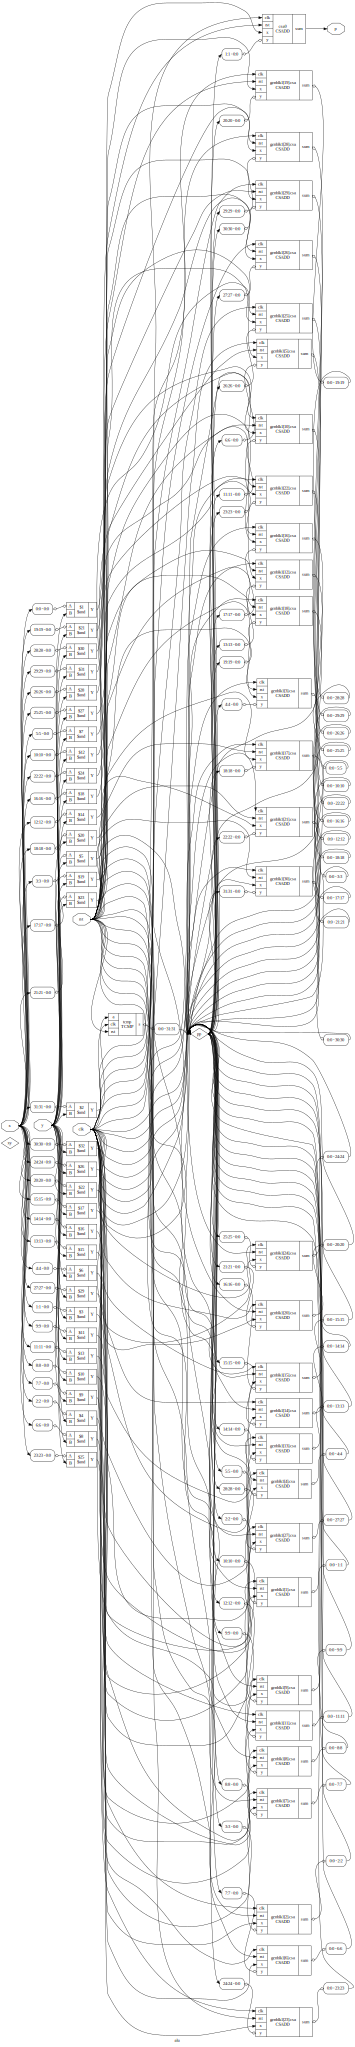

In [68]:
# @title Synthesis Result : Graph
import re
import graphviz
filepath ='./openlane_run/7-yosys-synthesis/hierarchy.dot'
def parse_verilog(file_path):
    """Extracts module instances and their connections from the synthesized Verilog file."""
    instances = {}
    module_name = None

    with open(file_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        line = line.strip()

        # Match module instantiations (e.g., NAND2X1 U1 (.A(A), .B(B), .Y(Y));)
        match = re.match(r"(\w+)\s+(\w+)\s*\((.*)\);", line)
        if match:
            gate_type, instance_name, connections = match.groups()
            instances[instance_name] = (gate_type, connections)

    return instances

def visualize_circuit(instances, output_file="synthesis_output"):
    """Generates a Graphviz visualization of the synthesized circuit."""
    dot = graphviz.Digraph(format="png")

    for instance, (gate_type, connections) in instances.items():
        dot.node(instance, f"{instance}\n({gate_type})", shape="box")

        # Extract signals (e.g., .A(A), .B(B), .Y(Y))
        for conn in re.findall(r"\.(\w+)\((\w+)\)", connections):
            pin, signal = conn
            dot.edge(signal, instance, label=pin)  # Connect signal to gate

    dot.render(output_file)
    print(f"Graph saved as {output_file}.png")
    # Usage
synthesized_netlist = filepath # Replace with your synthesized Verilog file
instances = parse_verilog(synthesized_netlist)
visualize_circuit(instances)
from IPython.display import display, SVG

# Load and display the SVG
display(SVG("/content/synthesis.svg"))

### Floorplanning

Floorplanning does two things:

* Determines the dimensions of the final chip.
* Creates the "cell placement grid" which placed cells must be aligned to.
    * Each cell in the grid is called a "site." Cells can occupy multiple
      sites, with the overwhelming majority of cells occupying multiple sites
      by width, and some standard cell libraries supporting varying heights as well.

> Don't forget- you may call `display_help()` on any Step class to get a full
> list of configuration variables.


In [79]:
Floorplan = Step.factory.get("OpenROAD.Floorplan")

floorplan = Floorplan(state_in=synthesis.state_out)
floorplan.start()

──────────────────────────────────────────── Floorplan Initialization ─────────────────────────────────────────────

[17:34:01] VERBOSE  Running 'OpenROAD.Floorplan'…                                                      ]8;id=803969;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=782184;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[17:34:01] VERBOSE  Logging subprocess to ]8;id=573643;file:///content/openlane_run/8-openroad-floorplan/openroad-floorplan.log\openlane_run/]8;;\]8;id=519333;file:///content/openlane_run/8-openroad-floorplan/openroad-floorplan.log\8]8;;\]8;id=573643;file:///content/openlane_run/8-openroad-floorplan/openroad-floorplan.log\-openroad-floorplan/openroad-floorplan.log]8;;\…    ]8;id=949619;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=782053;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading technology LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef'…

[INFO ODB-0227] LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef, created
13 layers, 25 vias

Reading cell LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef'…

The NOWIREEXTENSIONATPIN statement will be ignored. See file                                                       
/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef at line 2.

[INFO ODB-0227] LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef, created 4 library
cells

Reading cell LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef'…

The NOWIREEXTENSIONATPIN statement will be ignored. See file                                                       
/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef at line 2.

[INFO ODB-0227] LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef, created 437      
library cells

Reading top-level netlist at '/content/openlane_run/7-yosys-synthesis/alu.nl.v'…

Linking design 'alu' from netlist…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

Using site height: 2.72 and site width: 0.46…

[INFO] Using relative sizing for the floorplan.

[INFO IFP-0001] Added 31 rows of 185 site unithd.

[INFO IFP-0030] Inserted 0 tiecells using sky130_fd_sc_hd__conb_1/LO.

[INFO IFP-0030] Inserted 0 tiecells using sky130_fd_sc_hd__conb_1/HI.

[INFO] Extracting DIE_AREA and CORE_AREA from the floorplan

[INFO] Floorplanned on a die area of 0.0 0.0 96.535 107.255 (µm).

[INFO] Floorplanned on a core area of 5.52 10.88 90.62 95.2 (µm).

Writing metric design__die__bbox: 0.0 0.0 96.535 107.255

Writing metric design__core__bbox: 5.52 10.88 90.62 95.2

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/8-openroad-floorplan/alu.odb'…

Writing netlist to '/content/openlane_run/8-openroad-floorplan/alu.nl.v'…

Writing powered netlist to '/content/openlane_run/8-openroad-floorplan/alu.pnl.v'…

Writing layout to '/content/openlane_run/8-openroad-floorplan/alu.def'…

Writing timing constraints to '/content/openlane_run/8-openroad-floorplan/alu.sdc'…

Format,Path
nl,openlane_run/8-openroad-floorplan/alu.nl.v
pnl,openlane_run/8-openroad-floorplan/alu.pnl.v
def,openlane_run/8-openroad-floorplan/alu.def
odb,openlane_run/8-openroad-floorplan/alu.odb
sdc,openlane_run/8-openroad-floorplan/alu.sdc


──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[17:34:08] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=938735;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=649804;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[17:34:08] VERBOSE  Logging subprocess to ]8;id=696343;file:///tmp/openlane_klayout_tmp_ohfddbv6/klayout-render.log\..]8;;\]8;id=599489;file:///tmp/openlane_klayout_tmp_ohfddbv6/klayout-render.log\/tmp/openlane_klayout_tmp_ohfddbv6/]8;;\]8;id=530922;file:///tmp/openlane_klayout_tmp_ohfddbv6/klayout-render.log\klayout-render.log]8;;\…     ]8;id=330154;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=334877;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 2.14s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
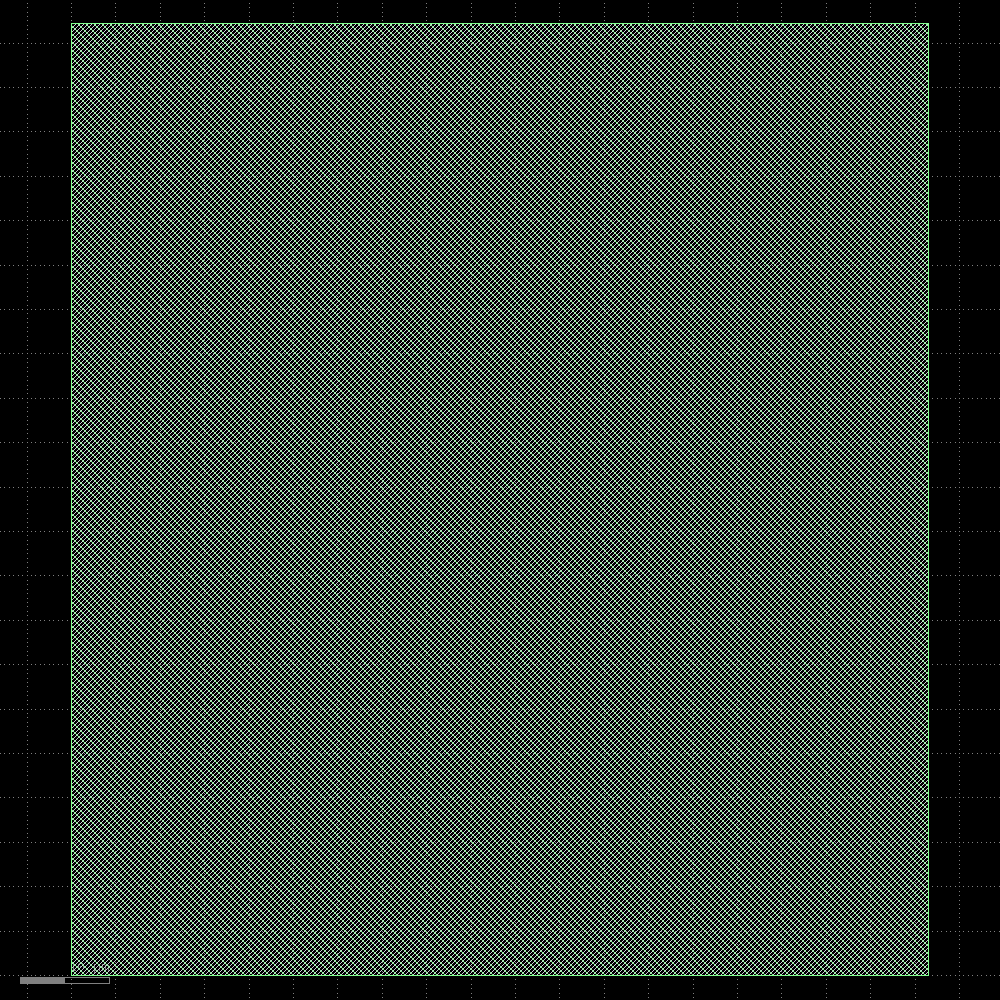

In [80]:
display(floorplan)

### Tap/Endcap Cell Insertion

This places two kinds of cells on the floorplan:

* End cap/boundary cells: Added at the beginning and end of each row. True to
  their name, they "cap off" the core area of a design.
* Tap cells: Placed in a polka dot-ish fashion across the rows. Tap cells
  connect VDD to the nwell and the psubstrate to VSS, which the majority of cells
  do not do themselves to save area- but if you go long enough without one such
  connection you end up with the cell "latching-up"; i.e.; refusing to switch
  back to LO from HI.

  There is a maximum distance between tap cells enforced as part of every
  foundry process.

In [81]:
TapEndcapInsertion = Step.factory.get("OpenROAD.TapEndcapInsertion")

tdi = TapEndcapInsertion(state_in=floorplan.state_out)
tdi.start()

─────────────────────────────────────────────── Tap/Decap Insertion ───────────────────────────────────────────────

[17:34:21] VERBOSE  Running 'OpenROAD.TapEndcapInsertion'…                                             ]8;id=276274;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=63953;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[17:34:21] VERBOSE  Logging subprocess to                                                              ]8;id=191632;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=589980;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=920133;file:///content/openlane_run/9-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\openlane_run/]8;;\]8;id=616499;file:///content/openlane_run/9-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\9]8;;\]8;id=920133;file:///content/openlane_run/9-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log]8;;\…                    

Reading OpenROAD database at '/content/openlane_run/8-openroad-floorplan/alu.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO TAP-0004] Inserted 62 endcaps.

[INFO TAP-0005] Inserted 99 tapcells.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/9-openroad-tapendcapinsertion/alu.odb'…

Writing netlist to '/content/openlane_run/9-openroad-tapendcapinsertion/alu.nl.v'…

Writing powered netlist to '/content/openlane_run/9-openroad-tapendcapinsertion/alu.pnl.v'…

Writing layout to '/content/openlane_run/9-openroad-tapendcapinsertion/alu.def'…

Writing timing constraints to '/content/openlane_run/9-openroad-tapendcapinsertion/alu.sdc'…

Format,Path
nl,openlane_run/9-openroad-tapendcapinsertion/alu.nl.v
pnl,openlane_run/9-openroad-tapendcapinsertion/alu.pnl.v
def,openlane_run/9-openroad-tapendcapinsertion/alu.def
odb,openlane_run/9-openroad-tapendcapinsertion/alu.odb
sdc,openlane_run/9-openroad-tapendcapinsertion/alu.sdc


──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[17:34:27] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=238663;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=868189;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[17:34:27] VERBOSE  Logging subprocess to ]8;id=879905;file:///tmp/openlane_klayout_tmp_sqj17rzl/klayout-render.log\..]8;;\]8;id=935887;file:///tmp/openlane_klayout_tmp_sqj17rzl/klayout-render.log\/tmp/openlane_klayout_tmp_sqj17rzl/]8;;\]8;id=526408;file:///tmp/openlane_klayout_tmp_sqj17rzl/klayout-render.log\klayout-render.log]8;;\…     ]8;id=276182;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=678509;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 0.92s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
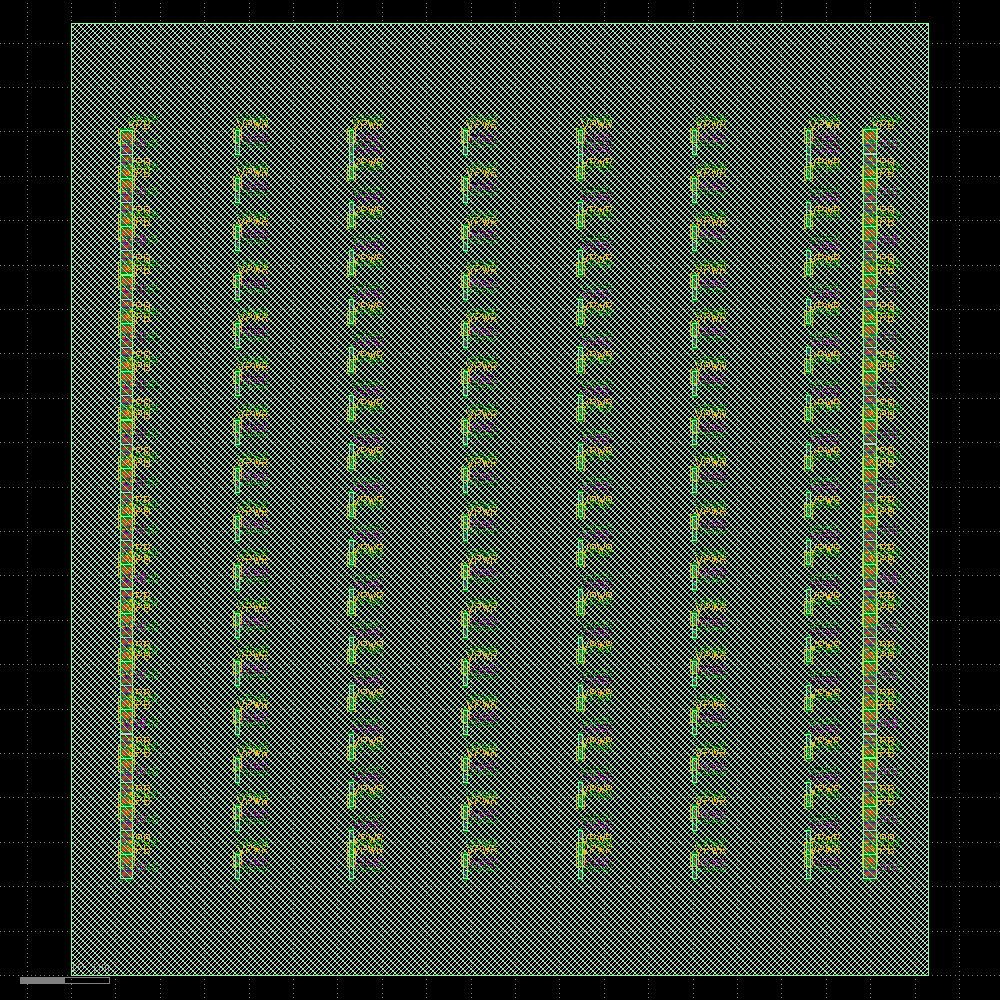

In [82]:
display(tdi)

### I/O Placement

This places metal pins at the edges of the design corresponding to the top level
inputs and outputs for your design. These pins act as the interface with other
designs when you integrate it with other designs.

In [83]:
IOPlacement = Step.factory.get("OpenROAD.IOPlacement")

ioplace = IOPlacement(state_in=tdi.state_out)
ioplace.start()

────────────────────────────────────────────────── I/O Placement ──────────────────────────────────────────────────

[17:34:42] VERBOSE  Running 'OpenROAD.IOPlacement'…                                                    ]8;id=760486;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=979988;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[17:34:42] VERBOSE  Logging subprocess to                                                              ]8;id=733442;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=154410;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=175291;file:///content/openlane_run/10-openroad-ioplacement/openroad-ioplacement.log\openlane_run/]8;;\]8;id=241017;file:///content/openlane_run/10-openroad-ioplacement/openroad-ioplacement.log\10]8;;\]8;id=175291;file:///content/openlane_run/10-openroad-ioplacement/openroad-ioplacement.log\-openroad-ioplacement/openroad-ioplacement.log]8;;\…                                 

Reading OpenROAD database at '/content/openlane_run/9-openroad-tapendcapinsertion/alu.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] place_pins args: -min_distance 3

Found 0 macro blocks.

[INFO PPL-0010] Tentative 0 to set up sections.

[INFO PPL-0001] Number of slots           124

[INFO PPL-0002] Number of I/O             36

[INFO PPL-0003] Number of I/O w/sink      36

[INFO PPL-0004] Number of I/O w/o sink    0

[INFO PPL-0005] Slots per section         200

[INFO PPL-0006] Slots increase factor     0.01

[INFO PPL-0008] Successfully assigned pins to sections.

[INFO PPL-0012] I/O nets HPWL: 2621.62 um.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/10-openroad-ioplacement/alu.odb'…

Writing netlist to '/content/openlane_run/10-openroad-ioplacement/alu.nl.v'…

Writing powered netlist to '/content/openlane_run/10-openroad-ioplacement/alu.pnl.v'…

Writing layout to '/content/openlane_run/10-openroad-ioplacement/alu.def'…

Writing timing constraints to '/content/openlane_run/10-openroad-ioplacement/alu.sdc'…

Format,Path
nl,openlane_run/10-openroad-ioplacement/alu.nl.v
pnl,openlane_run/10-openroad-ioplacement/alu.pnl.v
def,openlane_run/10-openroad-ioplacement/alu.def
odb,openlane_run/10-openroad-ioplacement/alu.odb
sdc,openlane_run/10-openroad-ioplacement/alu.sdc


──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[17:34:48] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=81753;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=464561;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[17:34:48] VERBOSE  Logging subprocess to ]8;id=75575;file:///tmp/openlane_klayout_tmp_hnetr0p8/klayout-render.log\..]8;;\]8;id=245098;file:///tmp/openlane_klayout_tmp_hnetr0p8/klayout-render.log\/tmp/openlane_klayout_tmp_hnetr0p8/]8;;\]8;id=346969;file:///tmp/openlane_klayout_tmp_hnetr0p8/klayout-render.log\klayout-render.log]8;;\…     ]8;id=316780;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=474985;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 0.92s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
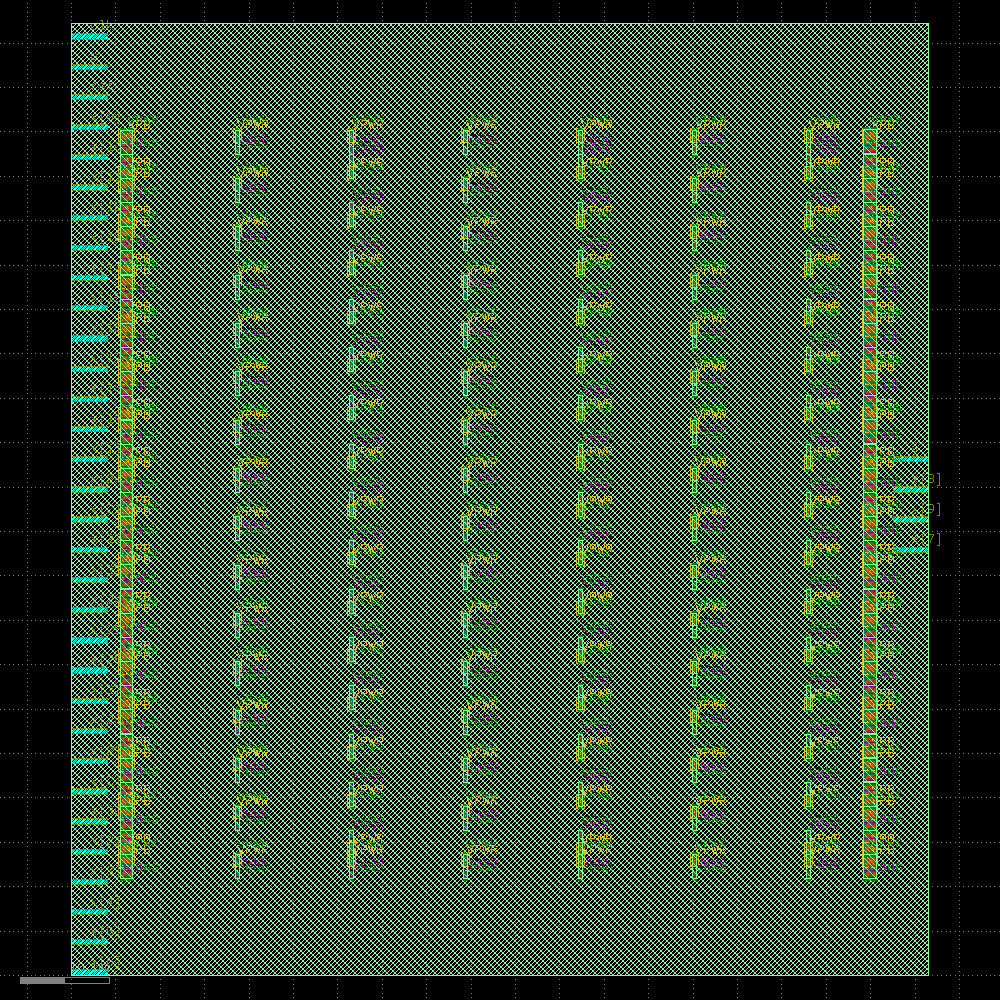

In [84]:
display(ioplace)

### Generating the Power Distribution Network (PDN)

This creates the power distribution network for your design, which is essentially
a plaid pattern of horizontal and vertical "straps" across the design that is
then connected to the rails' VDD and VSS (via the tap cells.)

You can find an explanation of how the power distribution network works at this
link: https://openlane2.readthedocs.io/en/latest/usage/hardening_macros.html#pdn-generation

While we typically don't need to mess with the PDN too much, the SPM is a small
design, so we're going to need to make the plaid pattern formed by the PDN a bit
smaller.

In [ ]:
GeneratePDN = Step.factory.get("OpenROAD.GeneratePDN")

pdn = GeneratePDN(
    state_in=ioplace.state_out,
    FP_PDN_VWIDTH=2,
    FP_PDN_HWIDTH=2,
    FP_PDN_VPITCH=30,
    FP_PDN_HPITCH=30,
)
pdn.start()

In [ ]:
display(pdn)

### Global Placement

Global Placement is deciding on a fuzzy, non-final location for each of the cells,
with the aim of minimizing the distance between cells that are connected
together (more specifically, the total length of the not-yet-created wires that
will connect them).

As you will see in the `.display()` in the second cell below, the placement is
considered "illegal", i.e., not properly aligned with the cell placement grid.
This is addressed by "Detailed Placement", also referred to as "placement
legalization", which is the next step.

In [ ]:
GlobalPlacement = Step.factory.get("OpenROAD.GlobalPlacement")

gpl = GlobalPlacement(state_in=pdn.state_out)
gpl.start()

In [ ]:
display(gpl)

### Detailed Placement

This aligns the fuzzy placement from before with the grid, "legalizing" it.

In [ ]:
DetailedPlacement = Step.factory.get("OpenROAD.DetailedPlacement")

dpl = DetailedPlacement(state_in=gpl.state_out)
dpl.start()

In [ ]:
display(dpl)

### Clock Tree Synthesis (CTS)

With the cells now having a final placement, we can go ahead and create what
is known as the clock tree, i.e., the hierarchical set of buffers used
for clock signal to minimize what is known as "clock skew"- variable delay
of the clock cycle from register to register because of factors such as metal
wire length, clock load (number of gates connected to the same clock buffer,)
et cetera.

The CTS step creates the cells and places the between the gaps in the detailed
placement above.

In [ ]:
CTS = Step.factory.get("OpenROAD.CTS")

cts = CTS(state_in=dpl.state_out)
cts.start()

In [ ]:
display(cts)

### Global Routing

Global routing "plans" the routes the wires between two gates (or gates and
I/O pins/the PDN) will take. The results of global routing (which are called
"routing guides") are stored in internal data structures and have no effect on
the actual design, so there is no `display()` statement.

In [ ]:
GlobalRouting = Step.factory.get("OpenROAD.GlobalRouting")

grt = GlobalRouting(state_in=cts.state_out)
grt.start()

### Detailed Routing

Detailed routing uses the guides from Global Routing to actually create wires
on the metal layers and connect the gates, making the connections finally physical.

This is typically the longest step in the flow.

In [ ]:
DetailedRouting = Step.factory.get("OpenROAD.DetailedRouting")

drt = DetailedRouting(state_in=grt.state_out)
drt.start()

In [ ]:
display(drt)

### Fill Insertion

Finally, as we're done placing all the essential cells, the only thing left to
do is fill in the gaps.

We prioritize the use of decap (decoupling capacitor) cells, which
further supports the power distribution network, but when there aren't any
small enough cells, we just use regular fill cells.

In [ ]:
FillInsertion = Step.factory.get("OpenROAD.FillInsertion")

fill = FillInsertion(state_in=drt.state_out)
fill.start()

In [ ]:
display(fill)

### Parasitics Extraction a.k.a. Resistance/Capacitance Extraction (RCX)

This step does not alter the design- rather, it computes the
[Parasitic elements](https://en.wikipedia.org/wiki/Parasitic_element_(electrical_networks))
of the circuit, which have an effect of timing, as we prepare to do the final
timing analysis.

The parasitic elements are saved in the **Standard Parasitics Exchange Format**,
or SPEF. OpenLane creates a SPEF file for each interconnect corner as described in
the [Corners and STA](https://openlane2.readthedocs.io/en/latest/usage/corners_and_sta.html)
section of the documentation.

In [ ]:
RCX = Step.factory.get("OpenROAD.RCX")

rcx = RCX(state_in=fill.state_out)
rcx.start()

### Static Timing Analysis (Post-PnR)

STA is a process that verifies that a chip meets certain constraints on clock
and data timings to run at its rated clock speed. See [Corners and STA](https://openlane2.readthedocs.io/en/latest/usage/corners_and_sta.html)
in the documentation for more info.

---

This step generates two kinds of files:
* `.lib`: Liberty™-compatible Library files. Can be used to do static timing
  analysis when creating a design with this design as a sub-macro.
* `.sdf`: Standard Delay Format. Can be used with certain simulation software
  to do *dynamic* timing analysis.

Unfortunately, the `.lib` files coming out of OpenLane right now are not super
reliable for timing purposes and are only provided for completeness.
When using OpenLane-created macros withing other designs, it is best to use the
macro's final netlist and extracted parasitics instead.

In [ ]:
STAPostPNR = Step.factory.get("OpenROAD.STAPostPNR")

sta_post_pnr = STAPostPNR(state_in=rcx.state_out)
sta_post_pnr.start()

### Stream-out

Stream-out is the process of converting the designs from the abstract formats
using during floorplanning, placement and routing into a concrete format called
GDSII (lit. Graphic Design System 2), which is the final file that is then sent
for fabrication.

In [ ]:
StreamOut = Step.factory.get("KLayout.StreamOut")

gds = StreamOut(state_in=sta_post_pnr.state_out)
gds.start()

In [ ]:
display(gds)

### Design Rule Checks (DRC)

DRC determines that the final layout does not violate any of the rules set by
the foundry to ensure the design is actually manufacturable- for example,
not enough space between two wires, *too much* space between tap cells, and so
on.

A design not passing DRC will typically be rejected by the foundry, who
also run DRC on their side.

In [ ]:
DRC = Step.factory.get("Magic.DRC")

drc = DRC(state_in=gds.state_out)
drc.start()

### SPICE Extraction for Layout vs. Schematic Check

This step tries to reconstruct a SPICE netlist from the GDSII file, so it can
later be used for the **Layout vs. Schematic** (LVS) check.

In [ ]:
SpiceExtraction = Step.factory.get("Magic.SpiceExtraction")

spx = SpiceExtraction(state_in=drc.state_out)
spx.start()

### Layout vs. Schematic (LVS)

A comparison between the final Verilog netlist (from PnR) and the final
SPICE netlist (extracted.)

This check effectively compares the physically implemented circuit to the final
Verilog netlist output by OpenROAD.

The idea is, if there are any disconnects, shorts or other mismatches in the
physical implementation that do not exist in the logical view of the design,
they would be caught at this step.

Common issues that result in LVS violations include:
* Lack of fill cells or tap cells in the design
* Two unrelated signals to be shorted, or a wire to be disconnected (most
  commonly seen with misconfigured PDN)

Chips with LVS errors are typically dead on arrival.

In [ ]:
LVS = Step.factory.get("Netgen.LVS")

lvs = LVS(state_in=spx.state_out)
lvs.start()